## Monitoring Math Performance of NYC Charter Schools

## Table of Contents

I. [Project Definition](#Project-Definintion)<br>
II. [Analysis](#Analysis)<br>
III. [Methodology](#Methodology)<br>
IV. [Result](#Result)<br>
V. [Conclusion](#Conclusion)<br>

## <a class="anchor" id="Project-Definition">Part I : Project Definition</a>

### Project Overview

Charter schools were established in the United States to offer free quality education to K-12 students at no cost. It is seen as a better alternative to public K-12 schools. Charter schools are frequently audited based on their students’ performance. Improving students’ academic performance is the aim of many charter schools in the United States. 

The project aims to track the performance of students that attend charter school in a specific subject like Math. The performance tracker gives the school leadership an insight of how students are performing in Math based on the percentage of students classified into 3 levels: Meeting Standards, Partially Meeting Standards, and Not Meeting Standards, after taking a test. The dataset for the project was gotten from https://opendata.cityofnewyork.us, New York City repository for publicly accessible dataset. 

### Project Statement
The goal of the project is to design an application to predict the performance ratio of students in Math in a specific charter school. The application predicts the percentage of students that would fall into each of the performance standards - Meeting Standards, Partially Meeting Standards, and Not Meeting Standards.

### Metrics
Root mean squared is the chosen metrics for the algorithm used to train the model in the project.

## <a class="anchor" id="Analysis">Part II : Analysis</a>



In [124]:
#Load libraries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import plotly
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
nyc_charter = pd.read_csv('Downloads/2013-2019_Math_Test_Results_Charter_-_School.csv')

### Understanding Data

In [3]:
#number of rows and columns in the dataset
nyc_charter.shape

(5267, 18)

In [113]:
#locate row with string data; expected numerical data
#nyc_charter.iloc[647,:]

In [5]:
#nyc_charter.loc[nyc_charter['School Name']=='EXCELLENCE BOYS CHARTER SCHOOL']

In [6]:
#check data types of each column
col_type = []
for i in nyc_charter.columns:
    col_type.append((i,nyc_charter[i].dtype))
print(col_type)

[('Unnamed Column', dtype('O')), ('DBN', dtype('O')), ('School Name', dtype('O')), ('Grade', dtype('O')), ('Year', dtype('int64')), ('Category', dtype('O')), ('Number Tested', dtype('int64')), ('Mean Scale Score', dtype('O')), ('# Level 1', dtype('O')), ('% Level 1', dtype('O')), ('# Level 2', dtype('O')), ('% Level 2', dtype('O')), ('# Level 3', dtype('O')), ('% Level 3', dtype('O')), ('# Level 4', dtype('O')), ('% Level 4', dtype('O')), ('# Level 3+4', dtype('O')), ('% Level 3+4', dtype('O'))]


In [7]:
#remove the unnamed column
nyc_charter.drop(labels='Unnamed Column', axis=1,inplace=True)

In [8]:
#check duplicates rows
nyc_charter[nyc_charter.duplicated(['DBN','Year','Grade'])]

,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4


In [9]:
#remove rows with missing data in almost all columns
nyc_charter = nyc_charter[~nyc_charter['# Level 1'].str.contains('s')]

In [10]:
#Convert data type of specific columns
nyc_charter['Year'] = pd.to_datetime(nyc_charter['Year'], format='%Y')

convert_dict = {'# Level 1':int,'% Level 1':float,
                '# Level 2':int,'% Level 2':float,
               '# Level 3':int,'% Level 3':float,
               '# Level 4':int, '% Level 4':float,
               '# Level 3+4':int,'% Level 3+4':float,
              'Mean Scale Score':float }
               
nyc_charter= nyc_charter.astype(convert_dict)

In [11]:
#check shape again
nyc_charter.shape

(5257, 17)

In [114]:
#nyc_charter.head()

### Reformat Data

In [13]:
#remove the category column since it contains same values for all rows; hence not a significant contributor
nyc_charter.drop('Category',axis=1,inplace=True)

In [14]:
#drop redundant columns
nyc_charter = nyc_charter[['DBN','School Name','Grade','Year','Number Tested',
                          'Mean Scale Score','% Level 1','% Level 2','% Level 3+4']]

In [15]:
#rename columns
nyc_charter.columns = ['DBN','School_Name','Grade','Year','Number_Tested',
                          'Mean_Scale_Score','Not_Meeting_Pct',
                       'Partially_Meeting_Pct','Meeting_Pct']

In [16]:
#check missing values
nyc_charter.isna().sum()

DBN                      0
School_Name              0
Grade                    0
Year                     0
Number_Tested            0
Mean_Scale_Score         0
Not_Meeting_Pct          0
Partially_Meeting_Pct    0
Meeting_Pct              0
dtype: int64

In [17]:
nyc_charter.sort_values(by='Year',inplace=True)

In [18]:
#nyc_charter.head()

### Describe Data

In [19]:
nyc_charter.describe(include=[np.number])

,Number_Tested,Mean_Scale_Score,Not_Meeting_Pct,Partially_Meeting_Pct,Meeting_Pct
count,5257.000000,5257.000000,5257.000000,5257.000000,5257.000000
mean,109.921248,419.147993,18.941088,29.183907,51.876869
std,103.734315,142.217901,15.898249,13.892715,25.150429
min,13.000000,257.000000,0.000000,0.000000,0.000000
25%,53.000000,307.000000,6.100000,20.600000,32.400000
50%,78.000000,326.000000,15.700000,30.800000,49.500000
75%,103.000000,601.000000,28.900000,39.000000,69.900000
max,755.000000,639.000000,92.300000,78.300000,100.000000


In [20]:
nyc_charter.describe(include=[object])

,DBN,School_Name,Grade
count,5257,5257,5257
unique,191,191,7
top,84K704,COMMUNITY PARTNERSHIP CHARTER SCHOOL,All Grades
freq,49,49,1081


In [115]:
#nyc_charter.head()

### Data Exploration

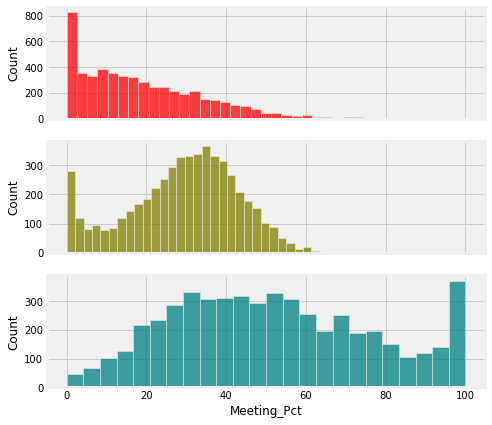

In [74]:
#distribution of performance levels columns
fig,axes = plt.subplots(3,1, figsize=(7,7), sharex=True)
sns.histplot(nyc_charter['Not_Meeting_Pct'], color='red',ax=axes[0])
sns.histplot(nyc_charter['Partially_Meeting_Pct'], color='olive',ax=axes[1])
sns.histplot(nyc_charter['Meeting_Pct'], color='teal',ax=axes[2])
plt.savefig('nyc_charter_levels.png',dpi=300, bbox_inches='tight')
plt.show()

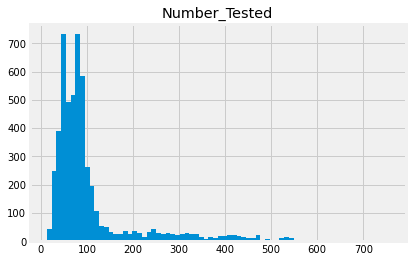

In [23]:
#distribution of the number of students taking the test
#use the square number to choose number of bins:sqrt(nyc_charter.shape[0])
nyc_charter.hist(column=['Number_Tested'],bins=int(np.sqrt(nyc_charter.shape[0])))
plt.savefig('nyc_number_tested.png',dpi=300, bbox_inches='tight')
plt.show()

This distribution is right_skewed. Many schools have 100 or less students sitting for the Math Exams yearly.

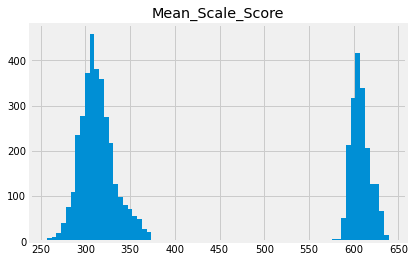

In [24]:
#distribution of the number of students taking the test
#use the square number to choose number of bins:sqrt(nyc_charter.shape[0])
nyc_charter.hist(column=['Mean_Scale_Score'],bins=int(np.sqrt(nyc_charter.shape[0])))
plt.savefig('nyc_mean_score.png',dpi=300, bbox_inches='tight')
plt.show()

The **Mean_Scale_Score** histogram depicts two populations in the dataset. A group of schools really doing well in the Math Tests and other group of schools struggling.

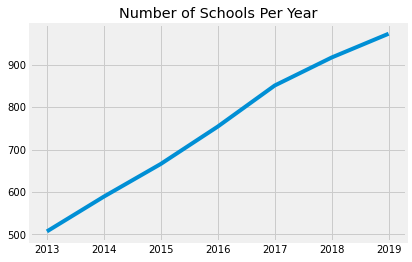

In [25]:
#plot number of schools taking test across the years
plt.plot(nyc_charter.groupby(nyc_charter['Year'])['DBN'].count())
plt.title("Number of Schools Per Year")
plt.savefig('nyc_number_schools.png',dpi=300, bbox_inches='tight')
plt.show()

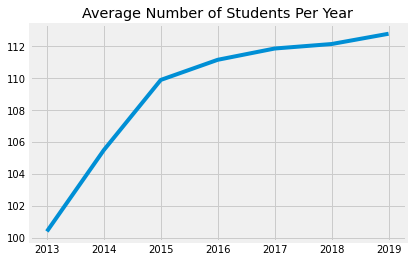

In [26]:
#plot average number of students taking test across the years
plt.plot(nyc_charter.groupby(nyc_charter['Year'])['Number_Tested'].mean())
plt.title("Average Number of Students Per Year")
plt.savefig('nyc_average_student.png',dpi=300, bbox_inches='tight')
plt.show()

The two line charts depicts the growing number of students in charter schools in NYC and possibly establishment of more charter schools as the years go by.

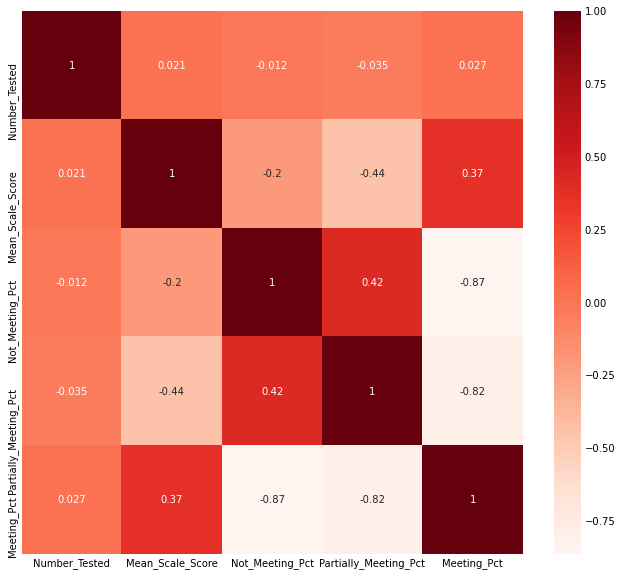

In [27]:
#plot the correlation matrix
correlation = nyc_charter.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.savefig('corr_matrix.png',dpi=300, bbox_inches='tight')
plt.show()


## <a class="anchor" id="Methodology">Part III : Methodology</a>

### Data PreProcessing

After much research into what algorithm would be suitable for the goal of this project- **Predict Performance Levels of Charter Schools in NYC**. The problem is classified as a Mulitvariate Multi-step Time Series Forecasting. Data Preperation has to be inline with the algorithm to be used. Vector Auto Regression (VAR) model would be suitable for the problem.VAR takes into consideration the previous occurence of variables and their dependencies when building building the model.  Here, only the target variables are needed in the dataset.


In [28]:
#store school ids and school names
school_ids = np.unique(nyc_charter['DBN'])
school_names = np.unique(nyc_charter['School_Name'])

In [29]:
#year range
print("Start Year :{}".format(min(nyc_charter['Year'])))
print("End Year :{}".format(max(nyc_charter['Year'])))

Start Year :2013-01-01 00:00:00
End Year :2019-01-01 00:00:00


#write reformatted data to file
nyc_charter.to_csv('nyc_charter_format.csv', index=False)

In [30]:
#select useful features 
nyc_charter_grp = nyc_charter[['DBN','Year','Not_Meeting_Pct','Partially_Meeting_Pct','Meeting_Pct']]

In [31]:
#group new dataset by DBN and Year
nyc_charter2 = nyc_charter_grp.groupby(['DBN','Year']).mean()

#write out the reformatted with group dataset to a csv file
nyc_charter2.to_csv('nyc_charter_grp.csv')

In [116]:
#nyc_charter.columns

In [33]:
#function subsets dataset to dataset of individual schools
def get_school_df(school_id,df = nyc_charter2):
    '''
    INPUT: (pandas dataframe) nyc_charter,
            (str) school_id
    OUTPUT: (pandas dataframe) school_df
    TASK: subset dataframe to consist of only one school
    '''
    school_df = df.loc[school_id]
    return school_df    

In [216]:
#test get_school_df
school = get_school_df('84K356')

In [217]:
school2 = get_school_df('84K517')

In [218]:
school3 = get_school_df('84K125')

In [117]:
#school

In [103]:
def get_school_id(name):
    '''
    INPUT: (str) school name
    OUTPUT: (str) school id
    TASK: get unique school id
    '''
    #school_ids = get_school_ids(forecast_models)
    school_id = np.unique(nyc_charter.loc[nyc_charter['School_Name']==name]['DBN']).tolist()

    return school_id

### Training Model

In [102]:
nyc = nyc_charter2.reset_index()
#nyc.head()


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

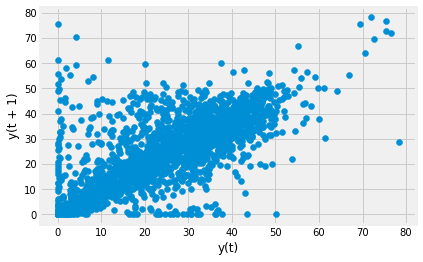

In [99]:
#The algorithm I intend to use to use for this building the model is Vector Autoregression.
#So I check the autocorrelation of the input features that are also the target variable
from pandas.plotting import lag_plot
lag_plot(nyc['Not_Meeting_Pct'])


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

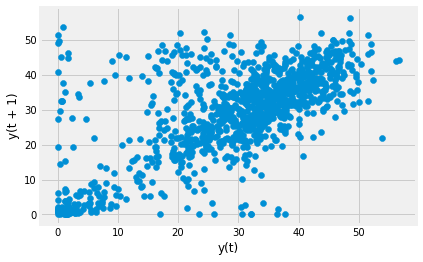

In [100]:
lag_plot(nyc['Partially_Meeting_Pct'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

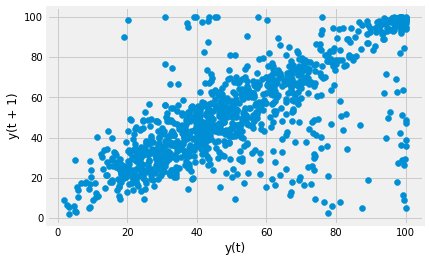

In [101]:
lag_plot(nyc['Meeting_Pct'])

In [126]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [127]:
#Check for Cointegration to test for non-stationary time series
cointegration_test(nyc[['Not_Meeting_Pct', 'Partially_Meeting_Pct','Meeting_Pct']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Not_Meeting_Pct ::  221.25    > 24.2761   =>   True
Partially_Meeting_Pct ::  92.42     > 12.3212   =>   True
Meeting_Pct ::  0.0       > 4.1296    =>   False


In [135]:
#Perform Unit Root Test; Check for stationarity
from statsmodels.tsa.stattools import adfuller
def adf(train_df):
    #Dickey-Fuller test
    print('Dickry-Fuller Test Result:')
    dftest = adfuller(train_df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used',
                                            'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# ADF Test on each column
adf(school['Not_Meeting_Pct'])
adf(school['Partially_Meeting_Pct'])
adf(school['Meeting_Pct'])  

Dickry-Fuller Test Result:
Test Statistic                -1.217161
p-value                        0.666170
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64
Dickry-Fuller Test Result:
Test Statistic                -0.121923
p-value                        0.947211
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64
Dickry-Fuller Test Result:
Test Statistic                -0.393919
p-value                        0.911109
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


In [141]:
# ADF Test on each column; school2
print('ADF Test for school with id 84K517')
adf(school2['Not_Meeting_Pct'])
adf(school2['Partially_Meeting_Pct'])
adf(school2['Meeting_Pct']) 
print(' ')

# ADF Test on each column; school3
print('ADF Test for school with id 84K125')
adf(school3['Not_Meeting_Pct'])
adf(school3['Partially_Meeting_Pct'])
adf(school3['Meeting_Pct']) 

ADF Test for school with id 84K517
Dickry-Fuller Test Result:
Test Statistic                -3.499179
p-value                        0.008008
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64
Dickry-Fuller Test Result:
Test Statistic                -2.213738
p-value                        0.201297
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64
Dickry-Fuller Test Result:
Test Statistic                -2.839055
p-value                        0.052908
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64

### Observation
* The ADF Test further ascertains that the schools should be treated as individual sites as some schools exhibit stationary data while other schools' data poorly depicts stationarity

* For this project, I made a assumption that the data is stationary and suitable for a timeseries model

<AxesSubplot:xlabel='Year'>

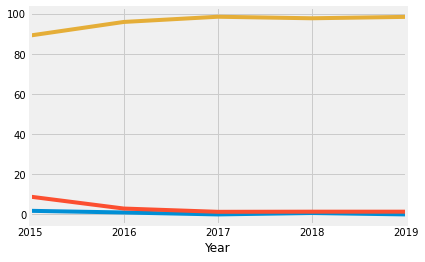

In [142]:
#Plot to visualize the trend in school id 84K125
school3['Not_Meeting_Pct'].plot()
school3['Partially_Meeting_Pct'].plot()
school3['Meeting_Pct'].plot()

### Challenges

* During the training process, an error with variable constancy was reported. A further research revealed that VAR being a time series model requires variability in the data. So I introduced noise data into the dataset to gain variability in the data.

* The Math scores were collected from multiple schools so the prediction needs to be per school. For that I planned to create a model for each school but some schools do not have enough data (schools with only a year data) to split into train and test for time series modeling so I removed them from the dataset.

* Prediction by school reduces sample size further. Unit test for stationarity like ADF (Augmented Dickey Fuller) Test could not be done. 

In [37]:
#function splits the data into train set and validation set

def train_valid_split(df):
    '''
    INPUT:(pandas dataframe) individual school dataframe
    OUTPUT: (pandas dataframe) train_df, valid_df
    TASK: split df into train set and validation set;
           validation set has records of most current year
    '''
    #add noise to data to add variance for VAR to work optimally
    #create noise with the same dimension as the subset data
    mu, sigma = 0,0.1
    nrow,ncol = df.shape[0],df.shape[1]
    noise = np.random.normal(mu, sigma,[nrow,ncol])
    df = df + noise
    cut_off = int(df.shape[0]*0.75)
    #split data into train set and validation set
    train_df = df[0:cut_off]
    valid_df = df[cut_off:]
    
    return train_df, valid_df

In [219]:
#test train_valid_split
t,v= train_valid_split(school)
#t,v

In [39]:
#function builds the model
def build_model(train):
    '''
    INPUT: (pandas dataframe) train dataframe
    OUTPUT: model_fit
    TASK: build forecast model for each school
    '''
    model = VAR(train)
    model_fit = model.fit()
    
    return model_fit
    

In [220]:
#test build_model
mod = build_model(t)

In [221]:
mod

In [163]:
cols = school.columns
#function makes prediction using the model
def predict(validation, model):
    '''
    INPUT: (pandas dataframe) validation set
           (timeseries model) model
    OUTPUT: prediction
    TASK: use model to make prediction
    '''
    prediction = model.forecast(model.y, steps=len(validation))
    
    #covert prediction to dataframe
    pred = pd.DataFrame(index = range(0,len(prediction)),columns=[cols])
    
    for i in range(0,3):
        for j in range(0, len(prediction)):
            pred.iloc[j][i] = prediction[j][i]
            
    return pred

In [222]:
#test predict
p = predict(v,mod)
p

,Not_Meeting_Pct,Partially_Meeting_Pct,Meeting_Pct
0,19.9298,29.7157,49.2705
1,44.6103,67.8351,-14.4564


In [165]:
#This function evaluates the model
def evaluate_model(pred, valid):
    '''
    INPUT: (pandas dataframe) prediction by model
            validation dataframe
    OUTPUT: root mean squared score for the three target variables
    TASK: evaluate the performance of the model
    '''
    for index,i in enumerate(valid.columns):
        print(i)
        print('rmse:{}'.format(math.sqrt(mean_squared_error(valid.iloc[:,index],pred.iloc[:,index])))) 
            

In [223]:
#test evaluate_model
evaluate_model(p,v)

Not_Meeting_Pct
rmse:27.060643039165157
Partially_Meeting_Pct
rmse:34.397144351485615
Meeting_Pct
rmse:62.84230720801726


In [48]:
#function builds models for individual schools and stores them in a dictionary
def build_allmodels(sch_ids):
    '''
    INPUT: (list) the ids of the schools
    OUTPUT: (dict) a dictionary mapping the school id to the school model
    TASK: build models for all the schools in the dataset
    '''
    all_models = dict()
    for ind in sch_ids:
        school_data = get_school_df(ind)
        train_data, validation_data = train_valid_split(school_data)
        try:
            school_model = build_model(train_data)
            all_models[ind]=school_model
        except ValueError: #raised if train_data is empty
            pass
    
    return all_models

In [553]:
#build_allmodels(school_ids)

In [104]:
#models = build_allmodels(school_ids)
#models

In [122]:
#build_allmodels(school_ids)


In [50]:
#get school ids that had models
school_ids_pred = []
for k,v in models.items():
    school_ids_pred.append(k)
#print(school_ids_pred)

In [143]:
#school_ids_pred

In [53]:
#get school names
school_names = np.unique(nyc_charter.loc[nyc_charter['DBN'].isin(school_ids_pred)]['School_Name']).tolist()
#school_names

In [54]:
#function evaluates the models
def evaluate_allmodels(models):
    '''
    INPUT: (dict) models for schools in the dataset
    OUTPUT: (float) root mean squared error of each model
    TASK: compute the rmse for the model
    
    '''
    for key, value in models.items():
        sub_data = get_school_df(key)
        t_data, v_data = train_valid_split(sub_data)
        #get prediction for each school's model
        preds = predict(v_data,models[key])
        print("The rmse score for school with id {}".format(key))
        evaluate_model(preds,v_data)
        print(' ')
    


In [168]:
#returns rmse for each school's model
#evaluate_allmodels(models)

In [152]:
school

,Not_Meeting_Pct,Partially_Meeting_Pct,Meeting_Pct
Year,,,
2013-01-01,16.671429,40.685714,42.628571
2014-01-01,15.257143,40.028571,44.700000
2015-01-01,13.714286,40.142857,46.185714
2016-01-01,7.800000,30.157143,62.042857
2017-01-01,9.357143,25.400000,65.228571
2018-01-01,10.942857,22.257143,66.800000
2019-01-01,7.528571,19.771429,72.714286


### Refinement
* To refine the the model I will run different lag order to pick the one that decreases the rmse.


In [210]:
#funtion to choose best VAR model
def refine_model(t):
    '''
    INPUT: (pandas dataframe) train dataframe
    OUTPUT: model_fit
    TASK: build forecast model for each school
    '''
  
    model = VAR(t)
    model_fit = model.fit(1)
    return model_fit
  
    
 

In [224]:
tr,te = train_valid_split(school)

In [227]:
#tr, te

In [226]:
#run the refine model to use lag order 1 using same sub dataset as before
model_tr = refine_model(tr)
#make prediction
pred_tr = predict(te,model_tr)
#evaluate model
evaluate_model(pred_tr,te)

Not_Meeting_Pct
rmse:24.944572165823786
Partially_Meeting_Pct
rmse:37.04252480472045
Meeting_Pct
rmse:63.23610798139349


## <a class="anchor" id="Result">Part IV : Result</a>

### Model Evaluation and Validation

The model accuracy score improves with the number of lags. Small sample size per school limits the use of more than 1 lag for the model to work well with all schools. Increasing the lag order would optimize the model for some schools while it could break the model in other schools.

For this dataset a lag order of 1 is chosen for the model training.

### Justification

* At the initial stage of the project, I considered using MultiOutput Regression model. But after researching and gaining more understanding of my project scope, I realised the presence of time and the prediction of time. VAR is a time series model and it takes the dependency of past events and other variables as a feed to occurence to the next time line. It captures the concentration of time in the project. VAR is one of the few time series algorithms that can predict mutivariate target variables.


* The introduction of noise data was very helpful in making the model robust to withstand constancy in the training data


## <a class="anchor" id="Conclusion">Part V : Conclusion</a>

The aim of the project is to forecast the trend of three performance levels in Math in NYC Charter Schools- Not Meeting Learning Standards, Partially Meeting Learning Standards, and Meeting Learning Standards. This project could help educators and superintendent of schools initiate early intervention in schools with high percentage of students falling behind.

School improvement could be measured and schools exceling could serve as a learning model for other schools in the district.

* Improvement:<br>
Getting more data for each school would improve the accuracy of the model's forecasting.

### References

* https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

* https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

* https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

* https://www.kaggle.com/sagivmal/var-prediction-on-coronavirus-italy